In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import testkit
import corner
import pickle as pickle
from IPython.display import display
%matplotlib inline
import forwardmodel
import ciamod
import TPmod
import cloud
import band
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from mikesconv import instrument_non_uniform

In [2]:
print forwardmodel.marv.__doc__


outspec,phot_press,tau_spec = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 array('d') wit

In [2]:
theta = np.array([ -3.31499795e+00,  -3.01934411e+00,  -8.89022408e+00,  -7.45070348e+00, -8.61199417e+00,-5.41448254e+00,-7.57607921e+00,-8.00500257e+00,-6.86818486e+00,  -6.72823719e+00 ,  5.25755550e+00 ,  3.27565843e-20,2.24816723e-03 , -3.10992392e+01 ,  4.09458386e+00 , -6.56249790e-01,1.50442020e+00,   2.98281853e-01 , -1.80780109e+00,   9.42121459e-01,1.13674914e-01 , -2.48313301e-01 ,  1.89107515e+00 ,  3.43942537e+03])

In [3]:
print theta.size

24


In [4]:
logP = np.arange(-4.0, 2.4, 0.1)  #high res grid
P = 10.**logP
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
print 10.**logcoarsePress
print logcoarsePress.size
print 10.**logP
print logP.size
finePress = P

[  1.00000000e-04   3.38844156e-04   1.14815362e-03   3.89045145e-03
   1.31825674e-02   4.46683592e-02   1.51356125e-01   5.12861384e-01
   1.73780083e+00   5.88843655e+00   1.99526231e+01   6.76082975e+01
   2.29086765e+02]
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.5118864

In [5]:
w1 = 0.7
w2 = 2.5

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds = 1
pcover = np.ones([npatches],dtype='f')
pcover[:] = 1.0
do_clouds = np.zeros([npatches],dtype='i')
do_clouds[:] = 1
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudtype = np.array([npatches],dtype='i')
cloudtype[:] = 1

use_disort = 0 

# Set the profile type
proftype = 2

# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 11
gasnum = np.asfortranarray(np.array([1,4,5,7,8,9,10,11,12,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/co2_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/mgh_xsecs.pic","../Linelists/K_xsecs.pic","../Linelists/Na_xsecs.pic"]

In [6]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [7]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')

In [8]:
alkratio = 16.2 # Asplund+ 2009
logVMR = np.asfortranarray(np.ones([ngas,64]),dtype='float64')


In [9]:
print forwardmodel.marv.__doc__

outspec,phot_press,tau_spec = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec)

Wrapper for ``marv``.

Parameters
----------
temp : input rank-1 array('d') with bounds (64)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : input rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 array('d') with bounds (f2py_cloudprof_d0,f

In [31]:
press = P
ng = 10
nc = 5
nb = 4
ndim = theta.size

obspec = np.loadtxt("2M2224_mkoJcalib.dat",unpack=True)
nobs = obspec.shape[1]

logVMR[0,:] = np.full((npress,),(theta[0])) # water
logVMR[1,:] = np.full((npress,),(theta[1])) # CO
logVMR[2,:] = np.full((npress,),(theta[2])) # CO2
logVMR[3,:] = np.full((npress,),(theta[3])) # TiO
logVMR[4,:] = np.full((npress,),(theta[4])) # VO
logVMR[5,:] = np.full((npress,),(theta[5])) # CaH
logVMR[6,:] = np.full((npress,),(theta[6])) # CrH
logVMR[7,:] = np.full((npress,),(theta[7])) # FeH
logVMR[8,:] = np.full((npress,),(theta[8])) # MgH
# Now the alkalis
logVMR[9,:]  = np.full((npress,),(np.log10(10.**theta[9] / (alkratio+1.))))
logVMR[10,:]  = np.full((npress,),(np.log10(10.**theta[9] * (alkratio / (alkratio+1.)))))
logg = theta[ng]
R2D2 = theta[ng+1]
dlam = theta[ng+2]
cloudparams = np.ones([5],dtype='d')
cloudparams[0] = theta[ng+4]
cloudparams[1] = theta[ng+5]
cloudparams[2] = theta[ng+6]
cloudparams[3] = theta[ng+7]
cloudparams[4] = theta[ng+8]
#cloudparams[1:5] = samp[ng+nb:ng+nb+nc]
cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)
cloudnum = np.asfortranarray(cloudnum,dtype='i')
cloudrad = np.asfortranarray(cloudrad,dtype='float64')
cloudsig = np.asfortranarray(cloudsig,dtype='float64')
cloudprof = np.asfortranarray(cloudprof,dtype='float64')
pcover = np.asfortranarray(pcover,dtype='float32')
do_clouds = np.asfortranarray(do_clouds,dtype='i')

tspec = 1
pspec = 1
npatch = 1
temp = TPmod.set_prof(2,10.**logcoarsePress,P,theta[ndim-5:])
tmpoutspec,tmpphotspec,tmptauspec = forwardmodel.marv(temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,pspec,tspec)
outspec = tmpoutspec[:,:nwave]
photspec = tmpphotspec[0:npatch,:nwave].reshape(nwave)
tauspec = tmptauspec[0:npatch,:nwave].reshape(nwave)
tempspec = TPmod.set_prof(2,10.**logcoarsePress,photspec,theta[ndim-5:])
wlen = outspec.shape[1]
shiftspec = np.empty_like(outspec)
shiftspec[0,:] =  outspec[0,:] + dlam
shiftspec[1,:] =  outspec[1,:]   
wavenew = obspec[0,:]
wno = 1e4 / shiftspec[0,:]
plotspec= instrument_non_uniform(obspec[0,:],wno,shiftspec[1,:])
plotphot = instrument_non_uniform(obspec[0,:],wno,photspec)
plottau = instrument_non_uniform(obspec[0,:],wno,tauspec)
plottemp = instrument_non_uniform(obspec[0,:],wno,tempspec)

In [32]:
print tauspec
print photspec.shape
print press.shape

[ 0.37172817  0.41751121  1.43146442 ...,  0.64974687  0.70470739
  0.73711929]
(10286,)
(64,)


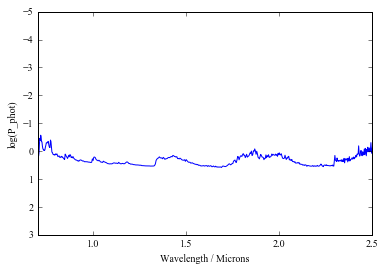

In [33]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7,2.5, 3.0,-5.])
plt.plot(wavenew,np.log10(plotphot))

plt.ylabel(r'log(P_phot)')
plt.xlabel('Wavelength / Microns')


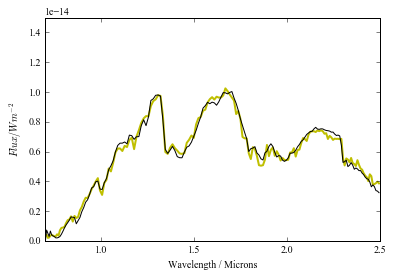

In [34]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7,2.5, 0.,15e-15])

plt.plot(wavenew[::3],plotspec[::3],'y-',linewidth=2)
plt.plot(obspec[0,::3],obspec[1,::3],'k-')
plt.ylabel(r'$Flux / Wm^{-2}$')
plt.xlabel('Wavelength / Microns')


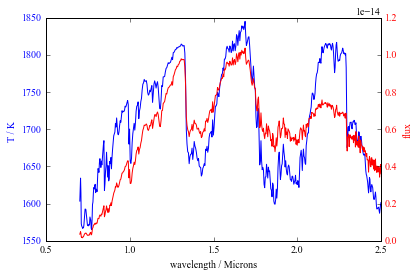

In [38]:
fig, ax1 = plt.subplots()
ax1.plot(wavenew,plottemp, 'b-')
ax1.set_xlabel('wavelength / Microns')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('T / K ', color='b')
#ax1.invert_yaxis()
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(wavenew,plotspec, 'r-')
ax2.set_ylabel('flux', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

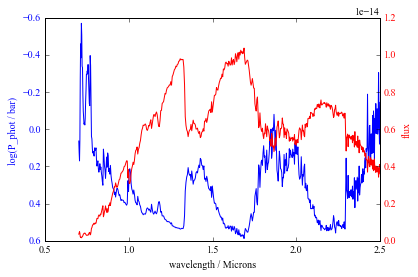

In [41]:
fig, ax1 = plt.subplots()
ax1.plot(wavenew,np.log10(plotphot), 'b-')
ax1.set_xlabel('wavelength / Microns')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('log(P_phot / bar) ', color='b')
ax1.invert_yaxis()
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(wavenew,plotspec, 'r-')
ax2.set_ylabel('flux', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()